# Tutorial 2: Filtering and Pre-Processing

This notebook shows how to pre-process and filter trajectory dataframes using `nomad`. The `nomad` library currently provides functions for coordinate-system projection, and spatial, temporal, and quantity filtering.

In [2]:
# %pip uninstall -y nomad
# %pip install -e ..

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from datetime import datetime
import matplotlib.patches as patches
from pyproj import Transformer

import nomad.io.base as loader
import nomad.filters as filters
from nomad.filters import to_projection, filter_users, q_filter
from nomad.constants import DEFAULT_SCHEMA
import nomad.city_gen as cg

### Load Data

For the following examples, we load test data from `nomad`. 

In [4]:
traj = loader.from_file('../nomad/data/gc_sample.csv', format='csv')

# create tz_offset column
traj['tz_offset'] = -18000

# create string datetime column
traj['local_datetime'] = loader.naive_datetime_from_unix_and_offset(
    traj['timestamp'], traj['tz_offset'])

# define schema/column names
traj_cols = DEFAULT_SCHEMA
traj_cols['user_id'] = 'uid'
traj_cols['datetime'] = 'local_datetime'

traj.head(10)

,uid,timestamp,latitude,longitude,tz_offset,local_datetime
0,wizardly_joliot,1704119340,38.321711,-36.667334,-18000,2024-01-01 09:29:00
1,wizardly_joliot,1704119700,38.321676,-36.667365,-18000,2024-01-01 09:35:00
2,wizardly_joliot,1704155880,38.320959,-36.666748,-18000,2024-01-01 19:38:00
3,wizardly_joliot,1704156000,38.320936,-36.666739,-18000,2024-01-01 19:40:00
4,wizardly_joliot,1704156840,38.320924,-36.666747,-18000,2024-01-01 19:54:00
5,wizardly_joliot,1704157860,38.320994,-36.666773,-18000,2024-01-01 20:11:00
6,wizardly_joliot,1704157920,38.320964,-36.666763,-18000,2024-01-01 20:12:00
7,wizardly_joliot,1704158820,38.320921,-36.666750,-18000,2024-01-01 20:27:00
8,wizardly_joliot,1704161280,38.320971,-36.666809,-18000,2024-01-01 21:08:00
9,wizardly_joliot,1704183120,38.321758,-36.666434,-18000,2024-01-02 03:12:00


### Project between coordinate systems

Many geospatial datasets come in spherical coordiantes latitude/longitude (EPSG:4326). However, spatial analyses---like joins of points in polygons, computing buffers, or clustering pings---might benefit from computing euclidean distances. Thus projected planar coordinates (like EPSG:3857) are commonly used. Nomad's `to_projection` method creates new columns `x` and `y` with projected coordinates in any coordinate reference system (CRS) recognized by PyProj. 


In [5]:
# Project to EPSG:3857 (Web Mercator)
projected_x, projected_y = to_projection(traj=traj,
                                         input_crs="EPSG:4326",
                                         output_crs="EPSG:3857",
                                         longitude="longitude",
                                         latitude="latitude")

traj['x'] = projected_x
traj['y'] = projected_y

traj.head(10)

,uid,timestamp,latitude,longitude,tz_offset,local_datetime,x,y
0,wizardly_joliot,1704119340,38.321711,-36.667334,-18000,2024-01-01 09:29:00,-4.081789e+06,4.624973e+06
1,wizardly_joliot,1704119700,38.321676,-36.667365,-18000,2024-01-01 09:35:00,-4.081792e+06,4.624968e+06
2,wizardly_joliot,1704155880,38.320959,-36.666748,-18000,2024-01-01 19:38:00,-4.081724e+06,4.624866e+06
3,wizardly_joliot,1704156000,38.320936,-36.666739,-18000,2024-01-01 19:40:00,-4.081723e+06,4.624863e+06
4,wizardly_joliot,1704156840,38.320924,-36.666747,-18000,2024-01-01 19:54:00,-4.081724e+06,4.624861e+06
5,wizardly_joliot,1704157860,38.320994,-36.666773,-18000,2024-01-01 20:11:00,-4.081727e+06,4.624871e+06
6,wizardly_joliot,1704157920,38.320964,-36.666763,-18000,2024-01-01 20:12:00,-4.081725e+06,4.624867e+06
7,wizardly_joliot,1704158820,38.320921,-36.666750,-18000,2024-01-01 20:27:00,-4.081724e+06,4.624861e+06
8,wizardly_joliot,1704161280,38.320971,-36.666809,-18000,2024-01-01 21:08:00,-4.081731e+06,4.624868e+06
9,wizardly_joliot,1704183120,38.321758,-36.666434,-18000,2024-01-02 03:12:00,-4.081689e+06,4.624980e+06


The following code visualizes the trajectory. We transform the coordinates in the sample data back to the Garden City coordinates (in a 22x22 box) so that we can visualize the city buildings alongside the blocks. The red box depicts the area we will filter to.

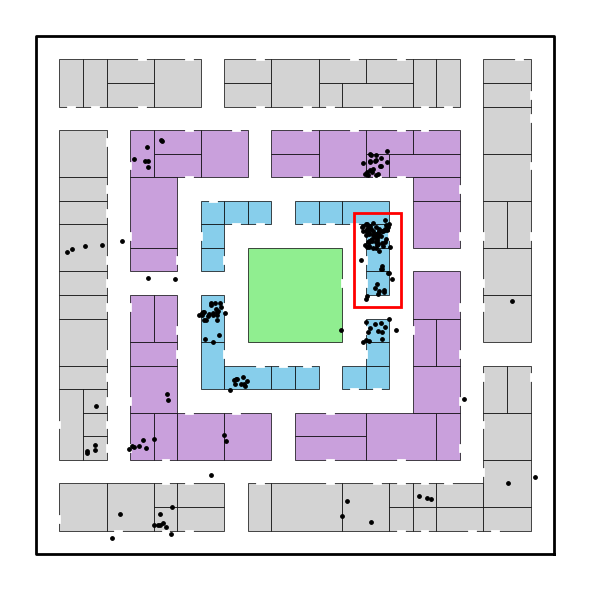

In [6]:
plot_df = traj[traj['uid'] == "agitated_chebyshev"].copy()
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_df['x'], plot_df['y'] = transformer.transform(plot_df['latitude'].values, plot_df['longitude'].values)
plot_df['x'] = (plot_df['x'] - 4265699)/15
plot_df['y'] = (plot_df['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

polygon_coords = [
    (13.5, 14.5), 
    (13.5, 10.5), 
    (15.5, 10.5), 
    (15.5, 14.5)
]
polygon = Polygon(polygon_coords)

polygon_patch = patches.Polygon(polygon.exterior.coords, closed=True, edgecolor='red', facecolor='none', linewidth=2, label="Polygon")
plt.gca().add_patch(polygon_patch)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

### Filter to a specified geometry

We often need to filter down the dataset to the most relevant records. This involves filtering along three key dimensions:
- Spatial Filtering: Keep only users with pings that fall within a specific geographic region (e.g., Philadelphia). Use the `polygon` argument.
- Temporal Filtering: Restrict data to a time window of interest (e.g., January). Use the `start_time` and `end_time` arguments. If 
- Quantity-Based Filtering: Keep only users with sufficient activity as measured by a minimum number of pings. Use the `min_active_days` and `min_pings_per_day` arguments.

If the aforementioned arguments are not specified, the default arguments ensure that the respective filtering is not performed. E.g., `polygon` defaults to `None`, and so no spatial filtering is performed.

These filtering functions help clean and prepare your dataset for downstream analysis by focusing only on users who are present, active, and engaged in the geographic area and timeframe you care about.

In [7]:
polygon_coords = [
    (-4.081775e+06, 4.62490e+06), 
    (-4.081775e+06, 4.62495e+06), 
    (-4.081725e+06, 4.62495e+06), 
    (-4.081725e+06, 4.62490e+06)
]
polygon = Polygon(polygon_coords)

n0 = len(traj)
uq0 = traj['uid'].unique()

filtered_traj = filter_users(traj=traj, 
                             start_time=pd.Timestamp("2024-01-01 00:00:00", tz='America/New_York'),
                             end_time=pd.Timestamp("2024-01-31 23:59:00", tz='America/New_York'),
                             polygon=polygon,
                             min_active_days=2,
                             min_pings_per_day=10,
                             user_id='uid',
                             x='x',
                             y='y')

n1 = len(filtered_traj)
uq1 = filtered_traj['uid'].unique()
print(f"Number of pings before filtering: {n0}")
print(f"Number of unique users before filtering: {len(uq0)}")
print(f"Number of pings after filtering: {n1}")
print(f"Number of unique users after filtering: {len(uq1)}")


Number of pings before filtering: 25835
Number of unique users before filtering: 100
Number of pings after filtering: 11083
Number of unique users after filtering: 16


### Visualize completeness and filter by completeness metric

The following code constructs a daily $Q$ matrix, which represents the completeness of user activity for each day. $q$ represents the proportion of hours in a day during which a specific user has recorded activity. A sliding window of 3 days is then applied to compute a mean completeness metric for each date in the sliding window.

In [ ]:
# Construct daily Q matrix
Q = filters._generate_Q_matrix(traj, traj_cols)
Q

# no need for sliding window
# visualize (1) distribution of q=0, (2) barcode 0/1 for each hour for each user

uid,admiring_curie,admiring_pike,adoring_einstein,adoring_northcutt,agitated_chebyshev,agitated_euclid,agitated_golick,amazing_nightingale,angry_johnson,angry_spence,...,vigorous_chaplygin,wizardly_joliot,wonderful_bell,wonderful_nobel,wonderful_swirles,youthful_boyd,youthful_galileo,zealous_cray,zealous_ramanujan,zen_colden
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0.000000,0.000000,0.208333,0.083333,0.000000,0.000000,0.375000,0.333333,0.000000,0.541667,...,0.041667,0.166667,0.125000,0.083333,0.041667,0.041667,0.791667,0.041667,0.083333,0.583333
2024-01-02,0.000000,0.041667,0.041667,0.166667,0.541667,0.708333,0.291667,0.125000,0.041667,0.583333,...,0.291667,0.416667,0.000000,0.000000,0.250000,0.208333,0.500000,0.083333,0.375000,0.708333
2024-01-03,0.083333,0.000000,0.041667,0.041667,0.750000,0.041667,0.500000,0.416667,0.000000,0.791667,...,0.250000,0.291667,0.000000,0.041667,0.041667,0.333333,0.500000,0.083333,0.250000,0.791667
2024-01-04,0.083333,0.083333,0.291667,0.041667,0.166667,0.083333,0.250000,0.291667,0.125000,0.750000,...,0.000000,0.125000,0.208333,0.000000,0.041667,0.208333,0.625000,0.083333,0.083333,0.625000
2024-01-05,0.000000,0.083333,0.000000,0.041667,0.208333,0.416667,0.125000,0.208333,0.083333,0.541667,...,0.416667,0.291667,0.083333,0.041667,0.083333,0.250000,0.708333,0.333333,0.000000,0.833333
2024-01-06,0.000000,0.208333,0.083333,0.125000,0.291667,0.041667,0.666667,0.083333,0.000000,0.666667,...,0.041667,0.208333,0.041667,0.083333,0.375000,0.333333,0.750000,0.333333,0.500000,0.916667
2024-01-07,0.000000,0.000000,0.125000,0.208333,0.166667,0.000000,0.333333,0.375000,0.208333,0.625000,...,0.250000,0.250000,0.250000,0.000000,0.041667,0.291667,0.708333,0.041667,0.666667,0.916667
2024-01-08,0.250000,0.000000,0.041667,0.208333,0.125000,0.083333,0.250000,0.541667,0.083333,0.791667,...,0.666667,0.291667,0.000000,0.000000,0.000000,0.500000,0.541667,0.166667,0.291667,0.875000
2024-01-09,0.083333,0.041667,0.416667,0.250000,0.000000,0.125000,0.458333,0.375000,0.083333,0.625000,...,0.208333,0.000000,0.166667,0.083333,0.000000,0.208333,0.583333,0.000000,0.166667,0.833333


In [ ]:
sliding_window = 3  # in days
SW_dates = Q.index[:-sliding_window]  # dates involved in the sliding window computation
Q_window = pd.DataFrame(
    [filters._compute_mean_q(Q, date, sliding_window) for date in SW_dates],
    index=SW_dates
    )

Q_window.head(5)

uid,admiring_curie,admiring_pike,adoring_einstein,adoring_northcutt,agitated_chebyshev,agitated_euclid,agitated_golick,amazing_nightingale,angry_johnson,angry_spence,...,vigorous_chaplygin,wizardly_joliot,wonderful_bell,wonderful_nobel,wonderful_swirles,youthful_boyd,youthful_galileo,zealous_cray,zealous_ramanujan,zen_colden
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0.027778,0.013889,0.097222,0.097222,0.430556,0.250000,0.388889,0.291667,0.013889,0.638889,...,0.194444,0.291667,0.041667,0.041667,0.111111,0.194444,0.597222,0.069444,0.236111,0.694444
2024-01-02,0.055556,0.041667,0.125000,0.083333,0.486111,0.277778,0.347222,0.277778,0.055556,0.708333,...,0.180556,0.277778,0.069444,0.013889,0.111111,0.250000,0.541667,0.083333,0.236111,0.708333
2024-01-03,0.055556,0.055556,0.111111,0.041667,0.375000,0.180556,0.291667,0.305556,0.069444,0.694444,...,0.222222,0.236111,0.097222,0.027778,0.055556,0.263889,0.611111,0.166667,0.111111,0.750000
2024-01-04,0.027778,0.125000,0.125000,0.069444,0.222222,0.180556,0.347222,0.194444,0.069444,0.652778,...,0.152778,0.208333,0.111111,0.041667,0.166667,0.263889,0.694444,0.250000,0.194444,0.791667
2024-01-05,0.000000,0.097222,0.069444,0.125000,0.222222,0.152778,0.375000,0.222222,0.097222,0.611111,...,0.236111,0.250000,0.125000,0.041667,0.166667,0.291667,0.722222,0.236111,0.388889,0.888889


We now visualize the number of complete users in each day for different values of completeness ($\bar{q} = 1-\epsilon$).

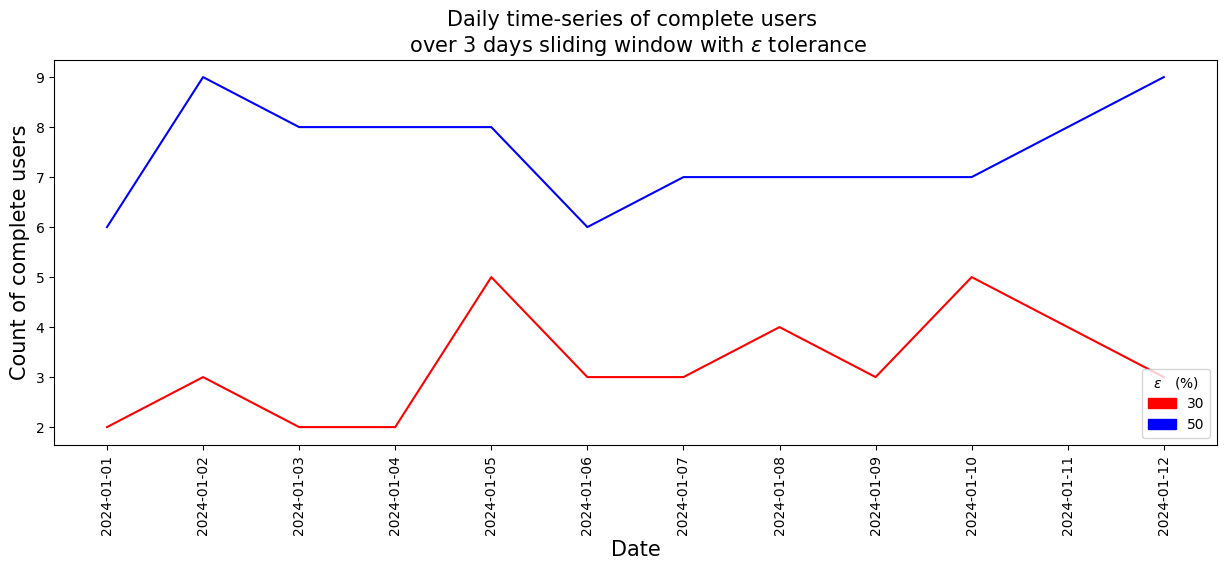

In [9]:
LIST_eps = [0.3,0.5]
Colors_eps = ['red', 'blue']
X = range(len(SW_dates))

DICT_legend= {'classes': [int(e*100) for e in LIST_eps], 
              'colors': Colors_eps, 
              'loc': 'lower right', 
              'fontsize':10,
              'title': '$\\epsilon \\quad (\\%)$', 
              'title_fontsize':10}

DICT_ticks = {'t': X, 
              'tl': SW_dates, 
              'rot': 90, 
              'size':10}

DICT_label_titles = {'xlabel': 'Date', 
                     'ylabel': 'Count of complete users', 
                     'title': f'Daily time-series of complete users \n over {sliding_window} days sliding window with $\\epsilon$ tolerance', 
                     'label_size': 15, 
                     'title_size': 15}

fig, ax = plt.subplots(figsize = (15,5))

for eps,color in zip(LIST_eps, Colors_eps):
    #Counts of complete users for each date - based on eps tolerance
    I_complete_eps = (Q_window > (1-eps)).sum(axis=1)
    ax.plot(X, I_complete_eps.values, color = color, label = eps)

filters._ax_visual_legend(ax, DICT_legend)
filters._ax_visual_ticklabel(ax, DICT_ticks, axis = 'x')
filters._ax_visual_labeltitles(ax, DICT_label_titles)

We can use $q$ to filter users by completeness, retaining only the users who exhibit a mean completeness of over `qbar` in the sample.

In [10]:
n0 = len(traj)
uq0 = traj['uid'].unique()

complete_users = q_filter(traj=traj,
                          qbar=0.7,
                          sliding_window=3,
                          traj_cols=traj_cols)
filtered_traj_q = traj[traj['uid'].isin(complete_users)]

n1 = len(filtered_traj_q)
uq1 = filtered_traj_q['uid'].unique()

print(f"Number of pings before filtering: {n0}")
print(f"Number of unique users before filtering: {len(uq0)}")
print(f"Number of pings after filtering: {n1}")
print(f"Number of unique users after filtering: {len(uq1)}")

Number of pings before filtering: 25835
Number of unique users before filtering: 100
Number of pings after filtering: 3506
Number of unique users after filtering: 3
